In [1]:
%%html
<style>
table {float:left}
</style>

# <font color="red">Session 4 Hard Challenge:</font><br>Classical Reservoir Computing

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To create and use a classical reservoir computing model in <strong>Python</strong>.<br>
            Compare this classical reservoir with the equivalent quantum reservoir.</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the the Mackey-Glass time series generator (code included)</td></tr>
    <tr><td><strong>Challenge<br>Tasks:</strong></td>
        <td>Unlimited time</td></tr>
    <tr>
        <td></td>
        <td>Perform the tasks listed in the notebook for the quantum reservoir model.<br>
            Use this implementation for the reference and comparison.</td>
    </tr>
    <tr><td><strong>References:</strong></td>
        <td><ul>
            <li><a href = "https://doi.org/10.1103/PhysRevApplied.14.024065" target="_blank">
                Chen, J., Nurdin, H.I., Yamamoto, N., 2020. Temporal Information Processing on Noisy Quantum Computers. Phys. Rev. Applied 14, 024065.
</a></li>
            <li><a href = "https://doi.org/10.1088/2634-4386/ac7db7" target="_blank">Cucchi, M., Abreu, S., Ciccone, G., Brunner, D., Kleemann, H., 2022. Hands-on reservoir computing: a tutorial for practical implementation. Neuromorph. Comput. Eng. 2, 032002. 
</a></li>
            <li><a href = "https://doi.org/10.1038/s41467-021-25801-2" target="_blank">Gauthier, D.J., Bollt, E., Griffith, A., Barbosa, W.A.S., 2021. Next generation reservoir computing. Nat Commun 12, 5564.
</a></li>
        </ul></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="https://creativecommons.org/licenses/by/4.0/" target="_blank">Creative Commons CC-BY</a></td></tr>
</table>

### Reservoir computing (RC)
RC is a concept derived from recurrent neural networks (RNN). 
It can be applied to all types of data, however, it is especially useful for temporal data. 
Reservoir computing utilises a large sparse neural network of randomly initialised and fixed weights (_**reservoir**_),
responsible for transforming input into a higher-dimensional space.
In high-dimensional space, data can be easily separated  (_**classified**_) by using a simple linear model (_**readout layer**_),
such a ridge regression.
The _**reservoir dynamics**_ can be specified by a set of differential equations (_**update rules**_)
responsible for describing changes to the reservoir state over time.

Typical reservoir computing applications include: time-series forecasting, speech recognition and video analysis, control of robots or autonomous vehicles, as well as, predicting weather patterns and stock markets.

## <font color="blue">Data preparation</font>

<font color="CornflowerBlue">In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).</font>

### Prepare synthetic time series data

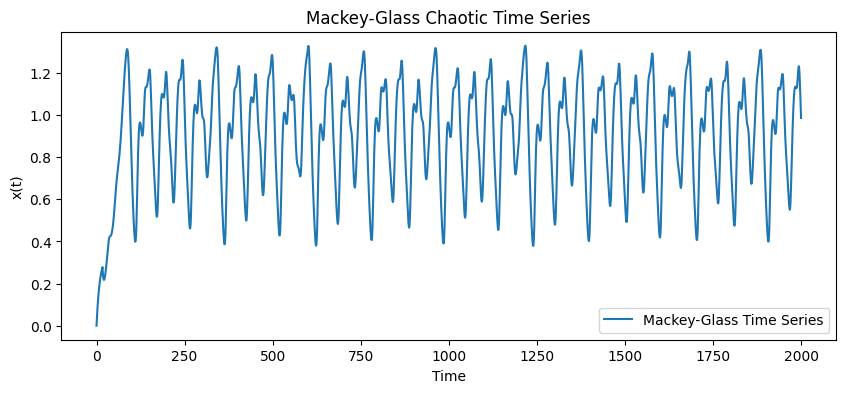

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
time_series = mackey_glass(dt=1, T=2000)

plt.figure(figsize=(10, 4))
plt.plot(time_series, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

### Prepare trainig and testing data partitions

In [3]:
### Prepare the data
def create_io_pairs(data, window_size):
    """
    Create input-output pairs for training/testing.
    """
    inputs = []
    outputs = []
    for i in range(len(data) - window_size):
        inputs.append(data[i:i + window_size])
        outputs.append(data[i + window_size])
    return np.array(inputs), np.array(outputs)

### Data settings
window_size = 10  # Use the last 10 time steps to predict the next step
train_size = 1000  # Use the first 1000 points for training
test_size = 500   # Use the next 500 points for testing

### Create data
train_inputs, train_outputs = create_io_pairs(time_series[:train_size], window_size)
test_inputs, test_outputs = create_io_pairs(time_series[train_size:train_size + test_size], window_size)

print(f"Training data shape: {train_inputs.shape}, {train_outputs.shape}")
print(f"Testing data shape: {test_inputs.shape}, {test_outputs.shape}")

Training data shape: (990, 10), (990,)
Testing data shape: (490, 10), (490,)


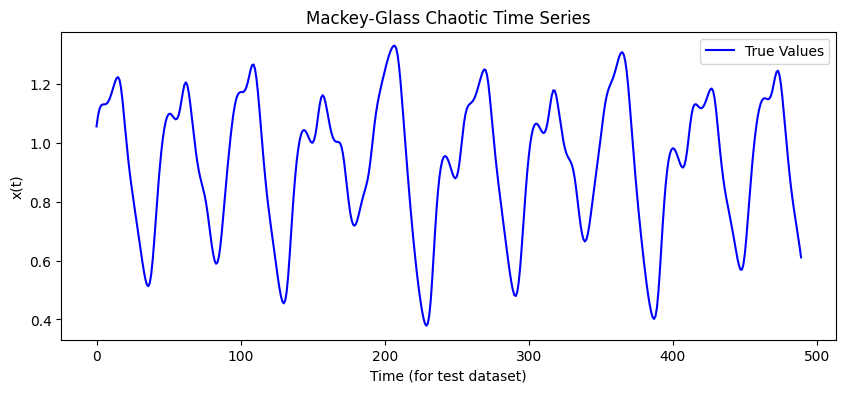

In [4]:
### Plot the test set
plt.figure(figsize=(10, 4))
plt.plot(test_outputs, label="True Values", color="blue")
plt.xlabel('Time (for test dataset)')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

## <font color="blue">Model development</font>

### Reservoir hyper-parameters

In [5]:
reservoir_size = 100
input_dim = window_size

### Initialize the reservoir

In [6]:
def initialize_reservoir(reservoir_size, input_dim, spectral_radius=0.9, sparsity=0.1, leakage_rate=0.3):
    
    # Input weights
    W_in = np.random.uniform(-0.1, 0.1, (reservoir_size, input_dim))

    # Set reservoir weights, but eliminate (1-sparsity) weights
    W_res = np.random.randn(reservoir_size, reservoir_size)
    W_res[np.random.rand(*W_res.shape) > sparsity] = 0

    # Scale spectral radius
    eigenvalues = np.linalg.eigvals(W_res)
    current_spectral_radius = np.max(np.abs(eigenvalues))
    W_res = (spectral_radius / current_spectral_radius) * W_res

    return W_in, W_res, leakage_rate

### Train the reservoir
*Includes the readout layer.*

In [7]:
# Update the reservoir state
def update_reservoir_state(input_seq, W_in, W_res, reservoir_state, leakage_rate):
    new_state = (1 - leakage_rate) * reservoir_state + \
                leakage_rate * np.tanh(W_in @ input_seq + W_res @ reservoir_state)
    return new_state

# Train the reservoir and compute the readout weights
def train_reservoir(train_inputs, train_outputs, W_in, W_res, leakage_rate):
    reservoir_states = []
    reservoir_state = np.zeros(reservoir_size)

    for input_seq in train_inputs:
        reservoir_state = update_reservoir_state(input_seq, W_in, W_res, reservoir_state, leakage_rate)
        reservoir_states.append(reservoir_state)

    # Stack reservoir states and outputs
    R = np.vstack(reservoir_states)
    Y = train_outputs.reshape(-1, 1)

    # Train readout weights using ridge regression
    lambda_reg = 1e-6  # Regularization parameter
    W_out = Y.T @ R @ np.linalg.inv(R.T @ R + lambda_reg * np.eye(reservoir_size))

    return W_out

### Predict the output from inputs

In [8]:
def predict(test_inputs, W_in, W_res, W_out, leakage_rate):
    predictions = []
    reservoir_state = np.zeros(reservoir_size)

    for input_seq in test_inputs:
        reservoir_state = update_reservoir_state(input_seq, W_in, W_res, reservoir_state, leakage_rate)
        y_pred = W_out @ reservoir_state
        predictions.append(y_pred[0])

    return np.array(predictions)

### Testing

In [9]:
# Initialise the reservoir
W_in, W_res, leakage_rate = initialize_reservoir(reservoir_size, input_dim)
print(f"\nReservoir weights shape: {W_res.shape}")
print(f"Input weights shape: {W_in.shape}")


Reservoir weights shape: (100, 100)
Input weights shape: (100, 10)


Readout weights shape: (1, 100)



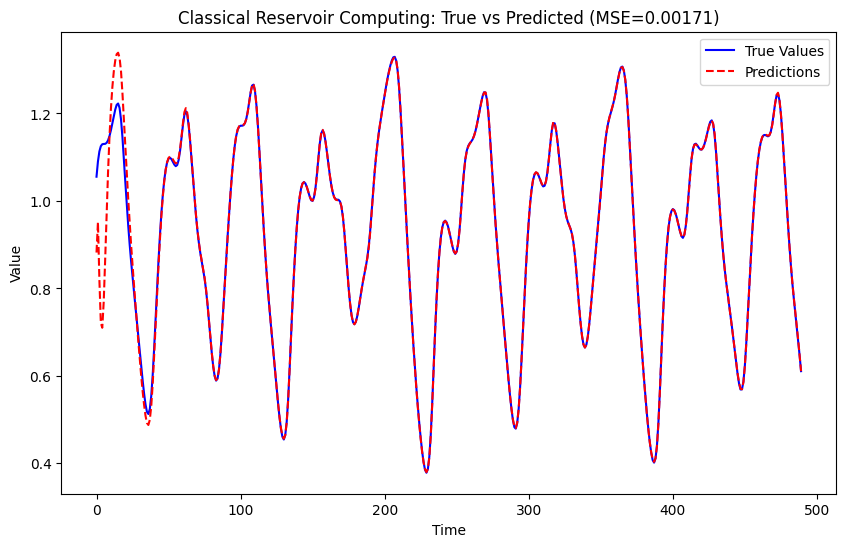

In [10]:
# Train the reservoir
W_out = train_reservoir(train_inputs, train_outputs, W_in, W_res, leakage_rate)
print(f"Readout weights shape: {W_out.shape}\n")

# Test reservoir
test_preds = predict(test_inputs, W_in, W_res, W_out, leakage_rate)

# Evaluate performance
mse = np.mean((test_outputs - test_preds)**2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label="Predictions", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f'Classical Reservoir Computing: True vs Predicted (MSE={np.round(mse, 5)})')
plt.legend()
plt.show()

### Experimenting with leakage

In [11]:
# Train with different leakage rates to find the optimum
leakage_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09]+\
                [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]+\
                [0.91, 0.93, 0.95, 0.97, 0.99]+\
                [0.993, 0.995, 0.997, 0.999]
leakage_rates = sorted(leakage_rates)

mse_scores = []
best_mse = 10000
best_params = None

# For reproducibility
np.random.seed(2025)
    
for rate in leakage_rates:
    W_out = train_reservoir(train_inputs, train_outputs, W_in, W_res, rate)
    test_preds = predict(test_inputs, W_in, W_res, W_out, rate)
    current_mse = np.mean((test_outputs - test_preds)**2)
    current_params = (rate, current_mse)
    mse_scores.append(current_params)
    print(f'Tested leakage rate: {rate}, mse: {np.round(current_mse, 4)}')
    
    if current_mse < best_mse:
        best_mse = current_mse
        best_params = current_params

Tested leakage rate: 0.01, mse: 2.1299
Tested leakage rate: 0.02, mse: 0.1478
Tested leakage rate: 0.03, mse: 0.1379
Tested leakage rate: 0.04, mse: 0.0132
Tested leakage rate: 0.05, mse: 0.0072
Tested leakage rate: 0.07, mse: 0.0098
Tested leakage rate: 0.08, mse: 0.0099
Tested leakage rate: 0.09, mse: 0.0076
Tested leakage rate: 0.1, mse: 0.0057
Tested leakage rate: 0.2, mse: 0.0063
Tested leakage rate: 0.3, mse: 0.0017
Tested leakage rate: 0.4, mse: 0.0023
Tested leakage rate: 0.5, mse: 0.0048
Tested leakage rate: 0.6, mse: 0.0049
Tested leakage rate: 0.7, mse: 0.0038
Tested leakage rate: 0.8, mse: 0.001
Tested leakage rate: 0.9, mse: 0.0013
Tested leakage rate: 0.91, mse: 0.0012
Tested leakage rate: 0.93, mse: 0.0008
Tested leakage rate: 0.95, mse: 0.0005
Tested leakage rate: 0.97, mse: 0.0004
Tested leakage rate: 0.99, mse: 0.0005
Tested leakage rate: 0.993, mse: 0.0005
Tested leakage rate: 0.995, mse: 0.0006
Tested leakage rate: 0.997, mse: 0.0006
Tested leakage rate: 0.999, mse:

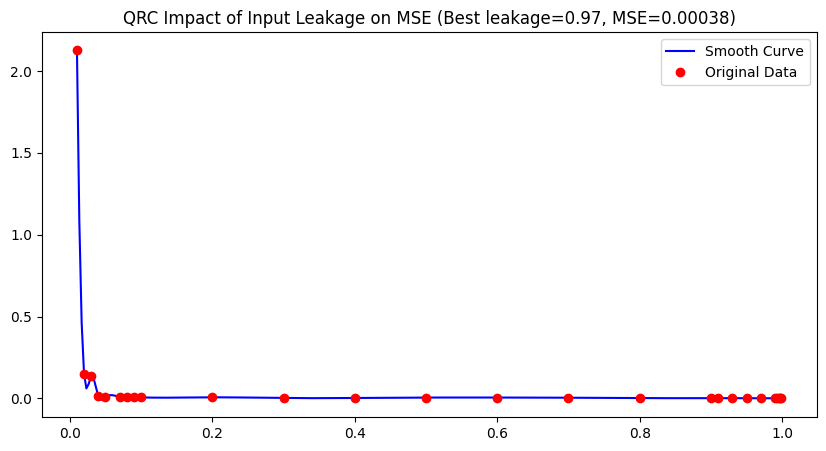

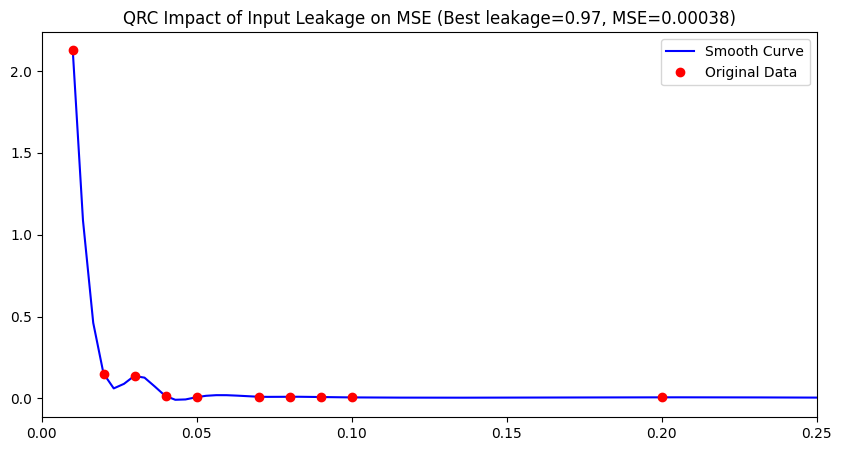

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Example data
X = np.array(leakage_rates)
y = np.array([mse for (rate, mse) in mse_scores])
best_rate, best_mse = best_params

# Generate smooth curve using spline interpolation
X_smooth = np.linspace(X.min(), X.max(), 300)  # 300 points for smoothness
spline = make_interp_spline(X, y, k=3)  # Cubic spline (k=3)
y_smooth = spline(X_smooth)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X_smooth, y_smooth, '-', color="blue", label="Smooth Curve")  # Smoothed line
plt.plot(X, y, 'o', color="red", label="Original Data")  # Original points
plt.title(f'QRC Impact of Input Leakage on MSE (Best leakage={best_rate}, MSE={np.round(best_mse, 5)})')
plt.legend()
plt.show()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X_smooth, y_smooth, '-', color="blue", label="Smooth Curve")  # Smoothed line
plt.plot(X, y, 'o', color="red", label="Original Data")  # Original points
plt.title(f'QRC Impact of Input Leakage on MSE (Best leakage={best_rate}, MSE={np.round(best_mse, 5)})')
plt.legend()
plt.xlim(0, 0.25)
plt.show()

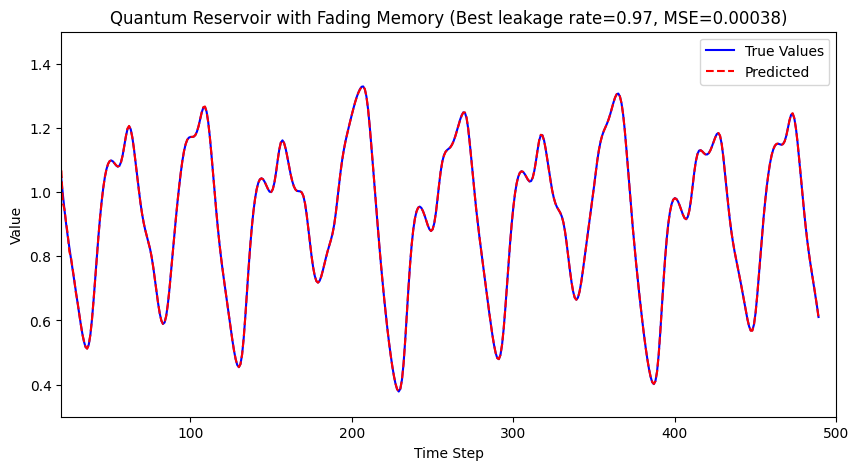

In [13]:
# Use best parameters for final prediction
best_rate, best_mse = best_params
plt.figure(figsize=(10, 5))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label=f"Predicted", color="red", linestyle="--")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.xlim(20, 500)
plt.ylim(0.3, 1.5)
plt.title(f'Quantum Reservoir with Fading Memory (Best leakage rate={best_rate}, MSE={np.round(best_mse, 5)})')
plt.legend()
plt.show()

# Software in use (Linux)

In [14]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
torch                     2.6.0
torchaudio                2.6.0
torcheval                 0.0.7
torchmetrics              1.6.1
torchsummary              1.5.1
torchvision               0.21.0
